# Programming Assignment #5: Convolutional Networks
Author: Pierre Nugues

<h2>Objectives</h2>

The objectives of this assignment are to:
* Write a program to recognize flowers on images
* Learn how to manage an image data set
* Apply convolutional networks to images
* Understand class activation
* Write a short report on your experiments. This report is mandatory to pass the assignment.

## Organization

Each group will have to:
* Write Python programs to recognize the type of flowers in an image.
* Experiment different neural architectures and compare the results.

Each student will have to:
* Run at home Chollet's notebook: `chapter09_part03_interpreting-what-convnets-learn.ipynb`. You can download from https://github.com/fchollet/deep-learning-with-python-notebooks.
* Write an individual report on these experiments.

While not compulsory, I highly recommend that you use Google colab and run your program on a GPU (Unless you have a GPU on your machine). This is something you select when you run the notebook (runtime type). You will have to create a Google account for this: https://colab.research.google.com

As there are a few parameterization steps, I recommend that you start this lab as early as you can.

## Collecting a Dataset

1. Register to Kaggle (https://www.kaggle.com/) to collect the datset used in this experiment. It is free and you will have access to lots of datasets. If you do not want to register, go to step 2.
2. Download the Flower corpus:
   * Either from Kaggle if you have registered (https://www.kaggle.com/alxmamaev/flowers-recognition). 
   * Or use a local copy, `flower-recognition.zip`, in the `datasets` folder in canvas.
3. Split randomly your dataset into training, validation, and test sets: Use a 60/20/20 ratio. You will read all the file names and create a list of pairs, (file_name, category). You will then shuffle your list and save your partition of the data. To speed up the lab, you can also:
   * Start with the partition available in the canvas folder (`flower_split.zip`); or
   * Run the code in the cells below (recommended).


In [33]:
import os
import random
import shutil
from tqdm import tqdm

# The machine name. Use the name colab is you run the code from Google colab
machine_name = 'filip'

# To create the same dataset
random.seed(0)

If you use Google colab (recommended). Use the GPU accelerator

In [34]:
if machine_name == 'colab':
    from google.colab import drive
    drive.mount("/content/drive")

In [35]:
# Here write the path to your dataset
if machine_name == 'vilde':
    base = '/home/pierre/Cours/EDAN95/datasets/'
if machine_name == 'mahir':
    base = '../'
    tf.config.set_soft_device_placement(True)
elif machine_name == 'filip':
    base = 'C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\'
elif machine_name == 'colab': # If you run your notebook with colab
    base = '/content/drive/My Drive/Colab Notebooks/'
else: # If you run your notebook on your machine
    base = 'your folder'

In [36]:
original_dataset_dir = os.path.join(base, 'flowers')
dataset = os.path.join(base, 'flowers_split')

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]
data_folders

Image types: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


['C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\flowers\\daisy',
 'C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\flowers\\dandelion',
 'C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\flowers\\rose',
 'C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\flowers\\sunflower',
 'C:\\Users\\filip\\Documents\\Högskola\\[EDAN95] - Applied Machine Learning\\lab_5\\flowers\\tulip']

We build the (image, label) pairs

In [37]:
pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])
pairs[:10]

[('100080576_f52e8ee070_n.jpg', 'daisy'),
 ('10140303196_b88d3d6cec.jpg', 'daisy'),
 ('10172379554_b296050f82_n.jpg', 'daisy'),
 ('10172567486_2748826a8b.jpg', 'daisy'),
 ('10172636503_21bededa75_n.jpg', 'daisy'),
 ('102841525_bd6628ae3c.jpg', 'daisy'),
 ('10300722094_28fa978807_n.jpg', 'daisy'),
 ('1031799732_e7f4008c03.jpg', 'daisy'),
 ('10391248763_1d16681106_n.jpg', 'daisy'),
 ('10437754174_22ec990b77_m.jpg', 'daisy')]

We define a split. We will run this part only once to create the partition into training, validation, and test sets.

In [38]:

random.shuffle(pairs)
img_nbr = len(pairs)
train_images = pairs[0:int(0.6 * img_nbr)]
val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
test_images = pairs[int(0.8 * img_nbr):]

# print(train_images)
print(len(train_images))
print(len(val_images))
print(len(test_images))

2590
863
864


We create the three subsets. We will run this part only once to create the partition into training, validation, and test sets.

In [39]:
if False:
    for image, label in tqdm(train_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(val_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(validation_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(test_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

## Building a Simple Convolutional Neural Network

### Architecture

Create a simple convolutional network and train a model with the training set. You can start from the architecture proposed by Chollet, Listing 8.7 (in Chollet's notebook chapter 8), and a small number of epochs. Use the `Rescaling` layer to scale your images as in the book:
```
layer.Rescaling(1.255)
```
* You will need to modify some parameters so that your network handles multiple classes.
* You will report the training and validation losses and accuracies and comment on the possible overfit.

In [40]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras import models
# from tensorflow.keras import optimizers
# from tensorflow.image import ResizeMethod

EPOCHS = 30
OPTIMIZER = 'rmsprop'
# The pretrained network
PRETRAINED = 'INCEPTION'

In [41]:
train_dataset = keras.utils.image_dataset_from_directory(
    os.path.join(base ,
        "flowers_split" ,
        "train")
    ,
    image_size=(180, 180),
    batch_size=64)

validation_dataset = keras.utils.image_dataset_from_directory(
    os.path.join(base, "flowers_split", "validation"),
    image_size=(180, 180),
    batch_size=64)

test_dataset = keras.utils.image_dataset_from_directory(
    os.path.join(base, "flowers_split", "test"),
    image_size=(180, 180),
    batch_size=64,
    shuffle=False)

Found 3632 files belonging to 5 classes.
Found 1555 files belonging to 5 classes.
Found 1563 files belonging to 5 classes.


Create the network and compile it

In [42]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.experimental.preprocessing.Rescaling(scale=1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(len(test_dataset.class_names), activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Compile your network

In [43]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [44]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 41, 41, 128)       7385

Create now the data readers for the training, validation, and test sets

You will now fit your model. Before, you will define a callback as in Chollet's book.

In [45]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="lab5.keras",
        save_best_only=True,
        monitor="val_loss")
]

And fit your model

In [46]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
57/57 [==============================] - 31s 520ms/step - loss: 1.8480 - accuracy: 0.3841 - val_loss: 1.2594 - val_accuracy: 0.4521
Epoch 2/20
57/57 [==============================] - 23s 399ms/step - loss: 1.1899 - accuracy: 0.5201 - val_loss: 1.0592 - val_accuracy: 0.6013
Epoch 3/20
57/57 [==============================] - 25s 431ms/step - loss: 0.9927 - accuracy: 0.6203 - val_loss: 1.1322 - val_accuracy: 0.5711
Epoch 4/20
57/57 [==============================] - 25s 439ms/step - loss: 0.8093 - accuracy: 0.6985 - val_loss: 0.7974 - val_accuracy: 0.7151
Epoch 5/20
57/57 [==============================] - 24s 414ms/step - loss: 0.6014 - accuracy: 0.7930 - val_loss: 0.6194 - val_accuracy: 0.8006
Epoch 6/20
57/57 [==============================] - 25s 432ms/step - loss: 0.3875 - accuracy: 0.8706 - val_loss: 0.8947 - val_accuracy: 0.7273
Epoch 7/20
57/57 [==============================] - 24s 422ms/step - loss: 0.2244 - accuracy: 0.9290 - val_loss: 0.6310 - val_accuracy: 0.8444

### Analyzing the fitting performance over epochs

As in Chollet's examples, show the training and validation loss

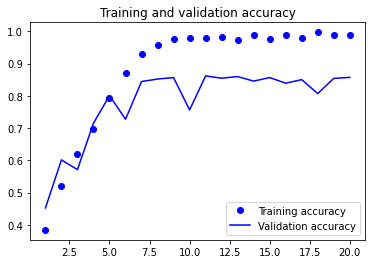

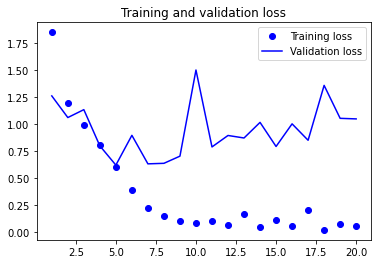

In [47]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Predicting the test set

You will now apply now your network to the test set. Read the best model from your checkpoints

In [48]:
test_model = keras.models.load_model('lab5.keras')

Predict the test set classes. Call the matrix of prediction probabilities `Y_pred` and the predicted classes `y_pred`. While predicting, extract the annotations that you will call `y_true`.

In [49]:
Y_pred = test_model.predict(test_dataset)
y_pred = [np.argmax(probability) for probability in Y_pred]
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

In [50]:
Y_pred[:5]

array([[0.33387107, 0.31313494, 0.06074269, 0.24686918, 0.04538219],
       [0.6638157 , 0.07362416, 0.10349477, 0.0906441 , 0.0684213 ],
       [0.8947955 , 0.08710446, 0.0033013 , 0.00140455, 0.01339415],
       [0.20544975, 0.66971624, 0.06020516, 0.00958357, 0.0550453 ],
       [0.7576709 , 0.10260876, 0.02116115, 0.0209005 , 0.09765873]],
      dtype=float32)

In [51]:
y_pred[:20]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0]

In [52]:
y_true[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Evaluate your model and report the loss and accuracy using Keras `evaluate()` function. You will store them in the `test_loss_1` and `test_acc_1` variables.

In [53]:
test_loss_1, test_acc_1 = test_model.evaluate(validation_dataset)
print(f"Test accuracy: {test_acc_1:.3f}")

25/25 [==============================] - 3s 110ms/step - loss: 0.6194 - accuracy: 0.8006
Test accuracy: 0.801


In [54]:
test_loss_1, test_acc_1

(0.6194152235984802, 0.8006430864334106)

Report the accuracy as well as the classification report. Use sklearn functions this time.

In [55]:
from sklearn import metrics

print(test_acc_1)
print(metrics.classification_report(y_true, y_pred))


0.8006430864334106
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       316
           1       0.77      0.88      0.82       374
           2       0.88      0.72      0.79       282
           3       0.89      0.75      0.81       250
           4       0.72      0.87      0.79       341

    accuracy                           0.80      1563
   macro avg       0.82      0.80      0.80      1563
weighted avg       0.82      0.80      0.80      1563



Print the confusion matrix. Use a sklearn function

In [56]:
metrics.confusion_matrix(y_true, y_pred)

array([[243,  36,   4,   8,  25],
       [ 16, 328,   4,   9,  17],
       [  6,  16, 203,   3,  54],
       [  5,  38,   1, 187,  19],
       [ 10,  10,  20,   4, 297]], dtype=int64)

Try to improve your model by modifying some parameters and evaluate your network again.

## Using Image Augmentation

### Architecture

The flower dataset is relatively small. A way to expand such datasets is to generate artificial images by applying small transformations to existing images. Keras provides built-in layers for this. You will reuse them and apply it to the flower data set.
1. Using the network from the previous exercise, apply some transformations to your images. You can start from Chollet, Listing 8.13 (in notebook 08 also).
2. Report the training and validation losses and accuracies and comment on the possible overfit.
3. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

Write a sequence of transformation layers

In [100]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
    ]
)

Define a model including these layers.

In [101]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(scale=1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(len(test_dataset.class_names), activation="softmax")(x)
model_augmented = keras.Model(inputs=inputs, outputs=outputs)


Compile your network

In [102]:
model_augmented.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [103]:
model_augmented.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_385 (Conv2D)          (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_386 (Conv2D)          (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 43, 43, 64)        0   

Define a callback to save your best model

In [104]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="lab5-augmented.keras",
        save_best_only=True,
        monitor="val_loss")
]

And fit your model

In [105]:
history_augmented = model_augmented.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
57/57 [==============================] - 27s 455ms/step - loss: 1.8335 - accuracy: 0.3987 - val_loss: 1.2208 - val_accuracy: 0.4482
Epoch 2/50
57/57 [==============================] - 27s 473ms/step - loss: 1.1886 - accuracy: 0.5229 - val_loss: 1.0815 - val_accuracy: 0.5685
Epoch 3/50
57/57 [==============================] - 28s 491ms/step - loss: 1.0806 - accuracy: 0.5666 - val_loss: 0.9468 - val_accuracy: 0.6334
Epoch 4/50
57/57 [==============================] - 27s 480ms/step - loss: 0.9852 - accuracy: 0.6220 - val_loss: 0.9742 - val_accuracy: 0.6225
Epoch 5/50
57/57 [==============================] - 28s 487ms/step - loss: 0.9287 - accuracy: 0.6415 - val_loss: 1.2683 - val_accuracy: 0.5466
Epoch 6/50
57/57 [==============================] - 27s 465ms/step - loss: 0.8879 - accuracy: 0.6718 - val_loss: 0.8566 - val_accuracy: 0.6701
Epoch 7/50
57/57 [==============================] - 28s 492ms/step - loss: 0.8261 - accuracy: 0.6836 - val_loss: 0.9991 - val_accuracy: 0.6386

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

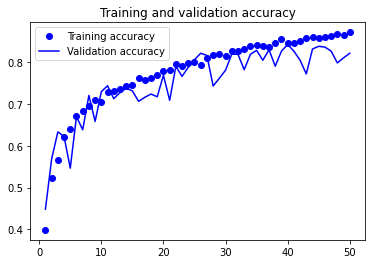

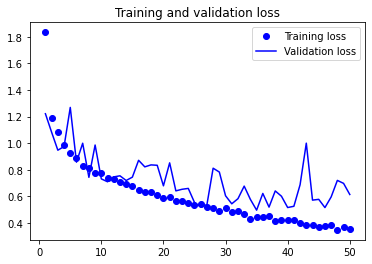

In [106]:
accuracy = history_augmented.history["accuracy"]
val_accuracy = history_augmented.history["val_accuracy"]
loss = history_augmented.history["loss"]
val_loss = history_augmented.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Predicting the test set

Load your best model

In [107]:
test_model = keras.models.load_model("lab5-augmented.keras")

Finally, run a model evaluation and store the loss and accuracy in the `test_loss_2` and `test_acc_2` variables.

In [108]:
test_loss_2, test_acc_2 = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc_2:.3f}")

25/25 [==============================] - 3s 117ms/step - loss: 0.4422 - accuracy: 0.8567
Test accuracy: 0.857


In [109]:
test_loss_2, test_acc_2

(0.44217947125434875, 0.8566858768463135)

In [110]:
Y_pred = test_model.predict(test_dataset)
y_pred = [np.argmax(probability) for probability in Y_pred]
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

metrics.confusion_matrix(y_true, y_pred)

array([[252,  30,  14,   4,  16],
       [ 14, 331,   6,  10,  13],
       [  8,  12, 235,   3,  24],
       [  7,   9,   5, 227,   2],
       [  4,  12,  30,   1, 294]], dtype=int64)

In [111]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       316
           1       0.84      0.89      0.86       374
           2       0.81      0.83      0.82       282
           3       0.93      0.91      0.92       250
           4       0.84      0.86      0.85       341

    accuracy                           0.86      1563
   macro avg       0.86      0.86      0.86      1563
weighted avg       0.86      0.86      0.86      1563



## Using a Pretrained Convolutional Base

### Architecture

Some research teams have trained convolutional neural networks on much larger datasets. We have seen during the lecture that the networks can model conceptual patterns as they go through the layers. This was identified by Le Cun in his first experiments [http://yann.lecun.com/exdb/lenet/](http://yann.lecun.com/exdb/lenet/). In this last part, you will train classifiers on top of a pretrained convolutional base.
1. Train your network and report the training and validation losses and accuracies.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [69]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [70]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(180, 180, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(180, 180, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_197 (Conv2D)             (None, 89, 89, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 89, 89, 32)   96          conv2d_197[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 89, 89, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

As in Chollet, Listing 8.20 (in Chollet's notebook 08), you will program a `get_features_and_labels()` function.

In [71]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = tf.keras.applications.inception_v3.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

The features and labels

In [72]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [73]:
train_features.shape
print(train_dataset)

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


Build a network that consists of the Inception V3 convolutional base and two dense layers.

In [74]:
inputs = keras.Input(shape=(4, 4, 2048))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)


In [75]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 4, 4, 2048)]      0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 1285      
Total params: 8,390,149
Trainable params: 8,390,149
Non-trainable params: 0
_________________________________________________________________


Compile your model

In [76]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Define a callback to save your best model

In [77]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="inception-v3-tip.keras",
      save_best_only=True,
      monitor="val_loss")
]

Fit your network

In [78]:
history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)


Epoch 1/30
114/114 [==============================] - 5s 43ms/step - loss: 46.0618 - accuracy: 0.6644 - val_loss: 13.5090 - val_accuracy: 0.8141
Epoch 2/30
114/114 [==============================] - 5s 43ms/step - loss: 20.7374 - accuracy: 0.7919 - val_loss: 19.7496 - val_accuracy: 0.7723
Epoch 3/30
114/114 [==============================] - 5s 42ms/step - loss: 13.8754 - accuracy: 0.8331 - val_loss: 16.0267 - val_accuracy: 0.8206
Epoch 4/30
114/114 [==============================] - 5s 41ms/step - loss: 9.2587 - accuracy: 0.8651 - val_loss: 18.9961 - val_accuracy: 0.7826
Epoch 5/30
114/114 [==============================] - 5s 40ms/step - loss: 7.2335 - accuracy: 0.8805 - val_loss: 5.7834 - val_accuracy: 0.9170
Epoch 6/30
114/114 [==============================] - 5s 41ms/step - loss: 5.5323 - accuracy: 0.8954 - val_loss: 7.2160 - val_accuracy: 0.8958
Epoch 7/30
114/114 [==============================] - 4s 39ms/step - loss: 4.3267 - accuracy: 0.9185 - val_loss: 5.6151 - val_accuracy:

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

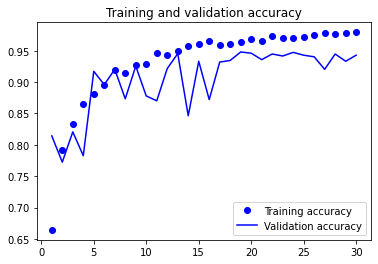

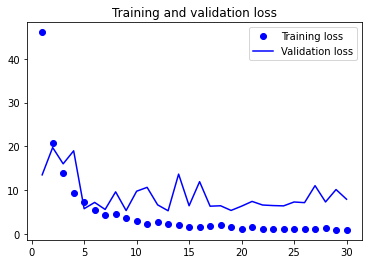

In [79]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Load your best model from the file

In [80]:
test_model = keras.models.load_model('inception-v3-tip.keras')

Evaluate your model and store the loss and accuracy in `test_loss_3`, `test_acc_3`

In [81]:
test_loss_3, test_acc_3 = test_model.evaluate(test_features, test_labels, 64)
print(f"Test accuracy: {test_acc_3:.3f}")


25/25 [==============================] - 0s 8ms/step - loss: 4.3354 - accuracy: 0.9501
Test accuracy: 0.950


In [82]:
test_loss_3, test_acc_3

(4.3354411125183105, 0.9500959515571594)

## Using a Pretrained Convolutional Base with Image Augmentation

### Architecture

1. Modify your program to include an image transformer. Train a new model. As a hint, use nadam or rmsprop as optimizer. Rescaling seems to lower the accuracy. Do not use it in your first attempts.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [83]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(180, 180, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(180, 180, 3))

You may want to try this first, and possibly modify it to improve the scores

In [84]:
conv_base.trainable = False

Create an image augmentation

In [85]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
    ]
)


Create your model

In [86]:

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)


Compile it

In [87]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [88]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 180, 180, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               8388

Write a callback to save your best model

In [89]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="lab5-pretrained-augmented-2.keras",
        save_best_only=True,
        monitor="val_loss")
]

Fit the model

In [90]:
history_augmented_2 = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
57/57 [==============================] - 45s 717ms/step - loss: 62.9240 - accuracy: 0.5867 - val_loss: 12.9416 - val_accuracy: 0.7942
Epoch 2/30
57/57 [==============================] - 40s 707ms/step - loss: 26.5214 - accuracy: 0.7227 - val_loss: 12.6076 - val_accuracy: 0.8039
Epoch 3/30
57/57 [==============================] - 41s 714ms/step - loss: 21.0980 - accuracy: 0.7539 - val_loss: 11.2248 - val_accuracy: 0.8289
Epoch 4/30
57/57 [==============================] - 41s 723ms/step - loss: 15.9143 - accuracy: 0.7874 - val_loss: 23.5785 - val_accuracy: 0.7518
Epoch 5/30
57/57 [==============================] - 40s 708ms/step - loss: 14.7035 - accuracy: 0.7822 - val_loss: 30.6500 - val_accuracy: 0.7125
Epoch 6/30
57/57 [==============================] - 40s 701ms/step - loss: 13.4716 - accuracy: 0.7979 - val_loss: 10.1009 - val_accuracy: 0.8238
Epoch 7/30
57/57 [==============================] - 40s 709ms/step - loss: 9.2539 - accuracy: 0.8188 - val_loss: 5.8506 - val_accu

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

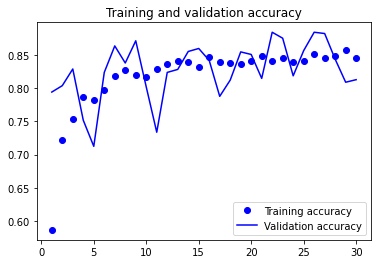

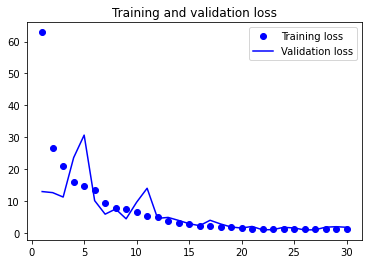

In [91]:
accuracy = history_augmented_2.history["accuracy"]
val_accuracy = history_augmented_2.history["val_accuracy"]
loss = history_augmented_2.history["loss"]
val_loss = history_augmented_2.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Load your best model

In [92]:
test_model = keras.models.load_model("lab5-pretrained-augmented-2.keras")

Evaluate it and store the loss and accuracy in `test_loss_4` and `test_acc_4`

In [93]:
test_loss_4, test_acc_4 = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc_4:.3f}")

25/25 [==============================] - 12s 407ms/step - loss: 0.7706 - accuracy: 0.8970
Test accuracy: 0.897


In [94]:
test_loss_4, test_acc_4

(0.7706391215324402, 0.8969929814338684)

### Predicting the test set

Apply now your network to the test set. You will collect `y_true` and `y_pred`

In [95]:
Y_pred = test_model.predict(test_dataset)
y_pred = [np.argmax(probability) for probability in Y_pred]
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

Report the accuracy as well as the classification report. Use sklearn functions

In [96]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       316
           1       1.00      0.85      0.92       374
           2       0.86      0.92      0.89       282
           3       0.88      0.86      0.87       250
           4       0.90      0.90      0.90       341

    accuracy                           0.90      1563
   macro avg       0.90      0.90      0.90      1563
weighted avg       0.90      0.90      0.90      1563



Print the confusion matrix

In [97]:
metrics.confusion_matrix(y_true, y_pred)

array([[303,   0,   4,   4,   5],
       [ 23, 318,   7,  17,   9],
       [  3,   0, 259,   5,  15],
       [ 23,   1,   4, 216,   6],
       [  5,   0,  27,   3, 306]], dtype=int64)

## Passing the Assignment

To pass the assignment, you need to reach an accuracy of 75 (even 80 ideally) with your best network.

In [99]:
(test_loss_1, test_acc_1), (test_loss_2, test_acc_2), (test_loss_3, test_acc_3), (test_loss_4, test_acc_4)

((0.6194152235984802, 0.8006430864334106),
 (0.6198227405548096, 0.7779910564422607),
 (4.3354411125183105, 0.9500959515571594),
 (0.7706391215324402, 0.8969929814338684))

## Report

You will write a short report of about two pages on your experiments:
1. You will describe all the architectures you designed and the results you obtained. You will summarize the results in a table. Your description should be one-page long;
2. You will run Chollet's notebook chapter09_part3 and read the article _Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization_ by Selvaraju et al. From this, you will reformulate and comment the paragraph on _Visualizing heatmaps of class activation_ in the notebook. Your analysis should be about one-page long.
3. You will run it on one of your flower images.

You will submit your report as well as your notebook through Canvas.